# Neural decoding: position on a multi-arm track (using decode tools)

Here is a full example of using the tools in the `fklab.decode` module to perform spike-sorting-less decoding of a subject's position in a maze from spiking activity recorded on multiple tetrodes. To check decoding performance, we perform cross-validation in which each trial is used in turn to test the encoding model that is built from the other trials.

## imports

In [ ]:
# import numerical libraries
import numpy as np
import scipy.interpolate

# the data is stored in a HDF5 file
# so import the tools to load HDF5 files
import h5py

# import plotting tools and set up
# inline figures for the notebook
import matplotlib.pyplot as plt

%matplotlib inline

# the description of the maze is encoded in YAML
# so let's import tools to parse YAML
import fklab.utilities.yaml as yaml

# importing the shapes module is needed to extend the YAML parser
# so that it recognizes YAML representations of shapes
import fklab.geometry.shapes

# import utilities to work with time segments
import fklab.segments

# finally, import the decoding tools
import fklab.decode
import fklab.decode_tools

## retrieve data

In [ ]:
import pathlib

root_path = pathlib.Path("~/notebook_data_cache").expanduser()
path = root_path.joinpath("decoding")

if not path.exists():
    path.mkdir(parents=True)

datafile = path.joinpath("processed_data.hdf5")

if not datafile.exists():
    from fklab.io.cloud import dropboxAPI

    dbx = dropboxAPI.from_token(
        os.environ.get("BITBUCKET_TOKEN")
    )  # Replace by your own token
    dbx.download("/Data/decoding/processed_data.hdf5", datafile)

## define parameters
Here we set parameters for data processing and decoding.

In [ ]:
# define trial epochs
trials = fklab.segments.Segment(
    [[2100, 2250], [2250, 2355], [2355, 2455], [2455, 2550], [2550, 2650]]
)
ntrials = len(trials)

# select spike data
tt_selection = [
    "TT1",
    "TT15",
    "TT16",
    "TT17",
    "TT19",
    "TT20",
    "TT23",
    "TT24",
    "TT5",
]  # tetrodes to be used for decoding
amp_threshold = (
    70.0  # uV, only use spikes with maximum amplitude larger than this threshold
)

# set kernel bandwidths and compression for encoding
pos_bw = 5.0  # cm, default spatial kernel bandwidth
amp_bw = 30.0  # uV, default spike amplitude kernel bandwidth
compression = 1.0  # kernel density compression Mahalanobis distance threshold

# set evaluation grid resolution
fine_grid_resolution = 2.0
# cm, spatial grid used to build squared distance matrix
grid_resolution = 4.0
# cm, spatial grid for decoding (should be multiple of fine grid)

# set behavior options
stim_sampling_frequency = 25.0  # Hz, sampling frequency of position tracking
speed_threshold = 10.0  # cm/s, only use data when animal runs faster than speed threshold for building encoding model

# set decoding options
decode_bin = 0.1  # seconds, bin size for run decoding

## maze definition and evaluation grid
Here we define the maze. Since the maze has multiple sections that meet at choice point, the maze is represented as a graph. Distances on the graph cannot simply be computed as the difference between (linearized) positions, so we precompute a squared distance matrix for a set of finely spaced linearized points on the maze.

In [ ]:
# define full maze
maze = "maze:\n  comments: ''\n  shapes:\n    track:\n      tags: [track]\n      comments: ''\n      shape: !graph_shape\n        nodes:\n        - [233.0, 145.0]\n        - [184.0, 145.0]\n        - [174.0, 168.0]\n        - [172.0, 120.0]\n        - [87.0, 245.0]\n        - [138.0, 0.0]\n        polylines:\n        - !polyline_shape\n          vertices:\n          - [233.0, 145.0]\n          - [184.0, 145.0]\n          spline: false\n        - !polyline_shape\n          vertices:\n          - [184.0, 145.0]\n          - [174.0, 168.0]\n          spline: false\n        - !polyline_shape\n          vertices:\n          - [184.0, 145.0]\n          - [172.0, 120.0]\n          spline: false\n        - !polyline_shape\n          vertices:\n          - [174.0, 168.0]\n          - [87.0, 245.0]\n          spline: false\n        - !polyline_shape\n          vertices:\n          - [172.0, 120.0]\n          - [138.0, 0.0]\n          spline: false\n    start:\n      tags: [field, ' reward']\n      comments: ''\n      shape: !rectangle_shape\n        center: [230.95882352941175, 144.93529411764706]\n        size: [40.92690758786794, 47.01063709417264]\n        orientation: 0.021273386024061366\n    B:\n      tags: [field, ' reward']\n      comments: ''\n      shape: !rectangle_shape\n        center: [142.0, 14.000000000000016]\n        size: [44.384682042344295]\n        orientation: 2.891149563978441\n    A:\n      tags: [field, ' reward']\n      comments: ''\n      shape: !rectangle_shape\n        center: [97.0, 238.0]\n        size: [42.5205832509386]\n        orientation: 2.4227626539681686\n"
maze = yaml.load(maze, Loader=yaml.FullLoader)

In [ ]:
maze_data, maze_converter = fklab.decode_tools.prepare_maze_for_encoding(
    maze["maze"]["shapes"]["track"]["shape"],
    dx=grid_resolution,
    oversampling=grid_resolution / fine_grid_resolution,
)

In [ ]:
pos_space, pos_grid = fklab.decode_tools.space_and_grid_from_maze(
    maze_data, bandwidth=pos_bw, direction=False
)

## preprocess behavioral and spiking data
Here we load the data and map (x,y) coordinates to (linearized) position on the maze.

In [ ]:
# load behavioral and ephys data
f = h5py.File(datafile, "r")

behavior = f["training/behavior"]

# map all xy positions to maze
linear_pos = maze["maze"]["shapes"]["track"]["shape"].point2path(
    behavior["positionsXY"][:]
)[0]


# create nearest neighbor interpolator for mapped positions for future use
linear_pos_interpolator = scipy.interpolate.interp1d(
    behavior["time"], linear_pos, kind="nearest", bounds_error=False
)

Next, we extract the times and amplitudes for all spikes and tetrodes.

In [ ]:
tt_data = f["training/ephys/MUA/tetrodes"]
tt_data = {
    k: {"time": v[0, :], "amplitude": v[1:, :].T, "width": np.zeros(v.shape[1])}
    for k, v in tt_data.items()
}

Define the spike amplitude space

In [ ]:
spike_space = fklab.decode_tools.spike_amp_encoding_space(n=4, bandwidth=amp_bw)

And we construct a list of run epochs where the subject ran faster than the speed threshold.

In [ ]:
# determine run epochs
with np.errstate(invalid="ignore"):  # get rid of annoying warning about NaNs
    run_epochs = fklab.segments.Segment.fromlogical(
        behavior["speed"][:] > speed_threshold, behavior["time"][:]
    )

## builder functions for decoder and data
For cross-validation, we need to rebuild the encoding model for different training data sets, and decode different test data sets. Below we define a decoder factory function that will accept all our stimulus and spike data and return a function that will build a new decoder for us given a set of training epochs.

In [ ]:
stim_time, stim, epochs = fklab.decode_tools.prepare_maze_stimulus(
    time=behavior["time"][:],
    position=linear_pos,
    direction=None,
    select_position=None,
    # epochs=run_epochs,
    convert_position=None,
)

spike_data = fklab.decode_tools.prepare_spike_data(
    data=tt_data,
    stimulus=linear_pos,
    stimulus_time=behavior["time"][:],
    select_tt=tt_selection,
    select_amp=amp_threshold,
    select_width=None,
    # epochs=run_epochs,
)

In [ ]:
# let's use the factory function to create our decoder building function for our data
data = dict(
    stimulus_space=pos_space,
    stimulus_grid=pos_grid,
    stimulus_duration=1.0 / stim_sampling_frequency,
    compression=compression,
    stimulus=stim,
    stimulus_time=stim_time,
    event_time=spike_data["time"].values(),
    event_data=spike_data["amplitude"].values(),
    event_stimulus=[v[:, None] for v in spike_data["stimulus"].values()],
    event_space=spike_space,
)


build_decoder = fklab.decode_tools.decoder_factory(**data)

We will use the same factory approach for constructing the test data sets.

In [ ]:
# let's use the factory function to create our data building function for our data
data = dict(
    decode_bin=decode_bin,
    event_time=spike_data["time"].values(),
    event_data=spike_data["amplitude"].values(),
)

build_data = fklab.decode_tools.data_factory(**data)

## perform cross-validation
Here we perform the cross-validation by looping through all trials and using the current trial to generate the test data set and the other trials to create the encoding model/decoder. Finally, we compute and collect the decoding error.

In [ ]:
cv = fklab.decode_tools.cv_epoch_fold(
    build_decoder, build_data, [run_epochs.intersection(k) for k in trials]
)
estimates, reals, errors, bins, posteriors = fklab.decode_tools.cross_validate(
    cv,
    lambda *args, **kwargs: linear_pos_interpolator(*args, **kwargs)[:, None],
    return_posterior=True,
)

In [ ]:
nodes = np.cumsum(
    [
        0.0,
    ]
    + maze["maze"]["shapes"]["track"]["shape"].edgelengths.tolist()
)

result = fklab.decode_tools.analyze_decoding_error(
    estimates, reals, errors, percentile=50, maze_nodes=nodes, direction=False
)

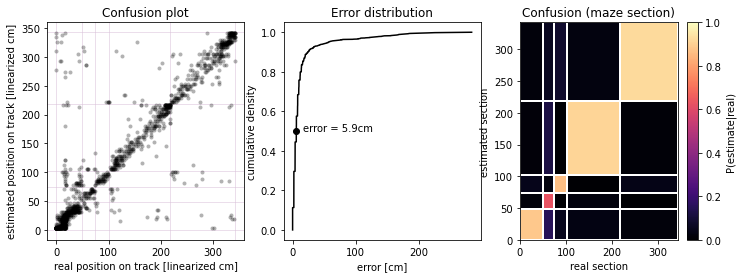

In [ ]:
fklab.decode_tools.visualize_decoding_error(
    estimates,
    reals,
    errors,
    percentile=50,
    maze_nodes=nodes,
    direction=False,
    square_heatmap=False,
);

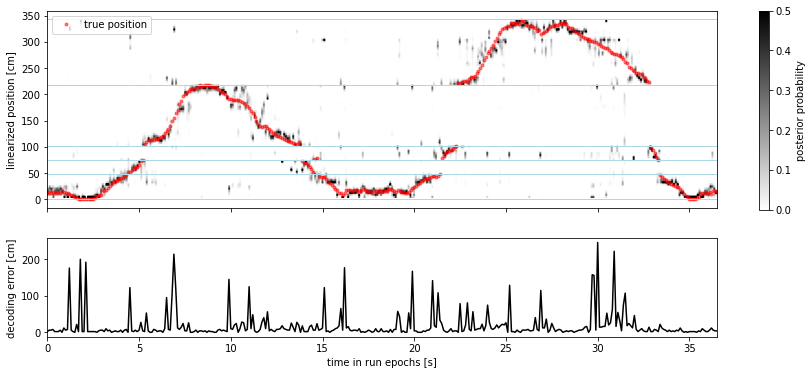

In [ ]:
fig, ax = plt.subplots(
    2, 1, figsize=(15, 6), sharex=True, gridspec_kw={"height_ratios": (2, 1)}
)

trial = 1

t = decode_bin * np.arange(posteriors[trial - 1].shape[0])

_, _, img = fklab.decode_tools.plot_posterior(
    posteriors[trial - 1].T,
    x=t,
    y=pos_grid.points(),
    colorbar=False,
    xlabel=None,
    ylabel="linearized position [cm]",
    ax=ax[0],
    scale=(0, 0.5),
    cmap="gray_r",
)

ax[0].plot(t, reals[trial - 1], "r.", alpha=0.5, label="true position")
ax[0].legend(loc="upper left")

for n in nodes:
    ax[0].axhline(n, color="lightblue", lw=1)

ax[1].plot(t, errors[trial - 1], "k")
ax[1].set(xlabel="time in run epochs [s]", ylabel="decoding error [cm]")

plt.colorbar(img, ax=ax, label="posterior probability", shrink=0.61, anchor=(0, 1));

## Save decoder

In [ ]:
test_trial = 1

# set training epochs to all trials except the test trial
training_epochs = run_epochs.intersection(
    trials[[trial for trial in range(1, ntrials + 1) if trial != test_trial]]
)

# construct decoder for current training epochs
decoder = build_decoder(epochs=training_epochs)

# Save
decoder_file = str(path.joinpath("decoder.hdf5"))
decoder.save_to_hdf5(decoder_file)

## Test saved decoder

In [ ]:
# load
z = fklab.decode.Decoder.load_from_hdf5(decoder_file)

In [ ]:
# test data during run maze arm runs for test trial only
test_epochs = run_epochs.intersection(trials[test_trial - 1])

# extract event data for each time bin
decode_segments, data, _ = build_data(epochs=test_epochs)

# perform decoding and concatenate posteriors
zposterior = [z.decode(x, decode_bin, True) for x in data]
zposterior = np.vstack(zposterior)

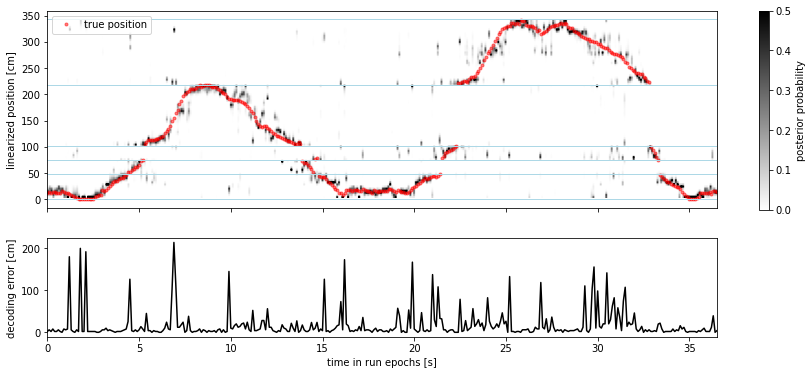

In [ ]:
fig, ax = plt.subplots(
    2, 1, figsize=(15, 6), sharex=True, gridspec_kw={"height_ratios": (2, 1)}
)

t = decode_bin * np.arange(posteriors[test_trial - 1].shape[0])

_, _, img = fklab.decode_tools.plot_posterior(
    zposterior.T,
    x=t,
    y=pos_grid.points(),
    colorbar=False,
    xlabel=None,
    ylabel="linearized position [cm]",
    ax=ax[0],
    scale=(0, 0.5),
    cmap="gray_r",
)

ax[0].plot(t, reals[test_trial - 1], "r.", alpha=0.5, label="true position")
ax[0].legend(loc="upper left")

for n in nodes:
    ax[0].axhline(n, color="lightblue", lw=1)

ax[1].plot(t, errors[test_trial - 1], "k")
ax[1].set(xlabel="time in run epochs [s]", ylabel="decoding error [cm]")

plt.colorbar(img, ax=ax, label="posterior probability", shrink=0.61, anchor=(0, 1));

## Explore contents of saved HDF5 file

In [ ]:
# define function to recursively get group keys
# based on: https://stackoverflow.com/a/59898173


def allkeys(obj, depth=100):
    "Recursively find all keys in an h5py.Group."
    keys = (obj.name,)

    if depth == 0:
        return keys

    if isinstance(obj, h5py.Group):
        for key, value in obj.items():
            if isinstance(value, h5py.Group):
                keys = keys + allkeys(value, depth - 1)
            else:
                keys = keys + (value.name,)
    return keys

In [ ]:
import h5py

hf = h5py.File(decoder_file, "r")

# look at top-level keys
print("Top level structure of file:\n")
for k in allkeys(hf, 2):
    print(k)

Top level structure of file:

/
/likelihood
/likelihood/likelihood_0_0
/likelihood/likelihood_1_0
/likelihood/likelihood_2_0
/likelihood/likelihood_3_0
/likelihood/likelihood_4_0
/likelihood/likelihood_5_0
/likelihood/likelihood_6_0
/likelihood/likelihood_7_0
/likelihood/likelihood_8_0
/nsources
/nunion
/priors
/priors/prior0
/selection
/stimulus
/stimulus/stimulus_0_0


In [ ]:
# Look at likelihood example
print("Structure of likelihood:\n")
for k in allkeys(hf["likelihood/likelihood_0_0"], 2):
    print(k)

Structure of likelihood:

/likelihood/likelihood_0_0
/likelihood/likelihood_0_0/event_distribution
/likelihood/likelihood_0_0/event_distribution/kernels
/likelihood/likelihood_0_0/event_distribution/nkernels
/likelihood/likelihood_0_0/event_distribution/space
/likelihood/likelihood_0_0/event_distribution/sum_of_nsamples
/likelihood/likelihood_0_0/event_distribution/sum_of_weights
/likelihood/likelihood_0_0/event_distribution/threshold
/likelihood/likelihood_0_0/event_distribution/weights
/likelihood/likelihood_0_0/random_insertion
/likelihood/likelihood_0_0/rate_scale


In [ ]:
# look at space

print("Structure of space:\n")
for k in allkeys(hf["stimulus/stimulus_0_0/stimulus_distribution/space"]):
    print(k)

print(
    "\nSpace class: {}".format(
        hf["stimulus/stimulus_0_0/stimulus_distribution/space/"].attrs["class"]
    )
)

Structure of space:

/stimulus/stimulus_0_0/stimulus_distribution/space
/stimulus/stimulus_0_0/stimulus_distribution/space/kernel
/stimulus/stimulus_0_0/stimulus_distribution/space/kernel/bw
/stimulus/stimulus_0_0/stimulus_distribution/space/kernel/loc
/stimulus/stimulus_0_0/stimulus_distribution/space/space
/stimulus/stimulus_0_0/stimulus_distribution/space/space/kernel
/stimulus/stimulus_0_0/stimulus_distribution/space/space/kernel/info
/stimulus/stimulus_0_0/stimulus_distribution/space/space/kernel/info/cutoff
/stimulus/stimulus_0_0/stimulus_distribution/space/space/kernel/type
/stimulus/stimulus_0_0/stimulus_distribution/space/space/lut
/stimulus/stimulus_0_0/stimulus_distribution/space/space/name
/stimulus/stimulus_0_0/stimulus_distribution/space/space/points

Space class: encoded


In [ ]:
# load only stimulus
stim = fklab.decode.Stimulus.load_from_hdf5(decoder_file, "/stimulus/stimulus_0_0")